# Part 1

---



>1.   In this section below function ***loadImages(path)*** is implemented. The function in order to operate needs to be given the filepath from google drive where the images are stored. The function when called, returns a dataframe with 30 lines with the image labels and the image vector mapped.



In [81]:
import numpy as np
import cv2
import glob
import pandas as pd
import matplotlib.image as image 
import matplotlib.pyplot as plt 


def findLabel(imageFileName, path):
  
  _ret = None
  
  imageFileName = imageFileName.replace(path+'/', '')
  if(imageFileName.find("W")!=-1):
    _ret = '0'
  elif(imageFileName.find("F")!=-1):
    _ret = '1'
  elif(imageFileName.find("S")!=-1):
    _ret = '2' 
  
  return _ret

def loadImages(path):
  
  seasons = pd.DataFrame([])
  img_label_list = []

  for imageFileName in glob.glob(path+"/*.jpg"):
    
    img = plt.imread(imageFileName)
    img=cv2.resize(img,(100,100))

    ##get labels
    label = findLabel(imageFileName, path)
    img_label_list.append(label)

    ##store image to dataframe
    img = pd.Series(img.flatten(),name=imageFileName)
    seasons = seasons.append(img)

  return seasons.T, img_label_list


path  = "/content/drive/My Drive/University/images"
seasons, img_label_arr = loadImages(path)
#display(img_label_arr)
seasons.head()

,/content/drive/My Drive/University/images/F6.jpg,/content/drive/My Drive/University/images/W6.jpg,/content/drive/My Drive/University/images/F1.jpg,/content/drive/My Drive/University/images/W4.jpg,/content/drive/My Drive/University/images/F3.jpg,/content/drive/My Drive/University/images/S2.jpg,/content/drive/My Drive/University/images/W1.jpg,/content/drive/My Drive/University/images/F10.jpg,/content/drive/My Drive/University/images/S10.jpg,/content/drive/My Drive/University/images/F9.jpg,/content/drive/My Drive/University/images/F7.jpg,/content/drive/My Drive/University/images/S8.jpg,/content/drive/My Drive/University/images/S7.jpg,/content/drive/My Drive/University/images/S6.jpg,/content/drive/My Drive/University/images/F4.jpg,/content/drive/My Drive/University/images/S3.jpg,/content/drive/My Drive/University/images/W10.jpg,/content/drive/My Drive/University/images/F8.jpg,/content/drive/My Drive/University/images/W7.jpg,/content/drive/My Drive/University/images/S4.jpg,/content/drive/My Drive/University/images/S9.jpg,/content/drive/My Drive/University/images/W9.jpg,/content/drive/My Drive/University/images/W2.jpg,/content/drive/My Drive/University/images/W8.jpg,/content/drive/My Drive/University/images/W5.jpg,/content/drive/My Drive/University/images/S1.jpg,/content/drive/My Drive/University/images/W3.jpg,/content/drive/My Drive/University/images/S5.jpg,/content/drive/My Drive/University/images/F2.jpg,/content/drive/My Drive/University/images/F5.jpg
0,37.0,146.0,90.0,56.0,13.0,47.0,151.0,172.0,73.0,60.0,63.0,45.0,1.0,134.0,31.0,1.0,59.0,136.0,244.0,171.0,60.0,69.0,147.0,47.0,193.0,0.0,149.0,26.0,51.0,155.0
1,95.0,153.0,59.0,63.0,11.0,34.0,158.0,155.0,79.0,30.0,45.0,58.0,1.0,130.0,40.0,1.0,53.0,76.0,237.0,229.0,69.0,71.0,152.0,68.0,208.0,4.0,154.0,3.0,22.0,116.0
2,107.0,166.0,5.0,72.0,12.0,23.0,169.0,144.0,87.0,6.0,3.0,50.0,1.0,69.0,49.0,1.0,50.0,13.0,228.0,253.0,25.0,83.0,156.0,98.0,215.0,0.0,157.0,20.0,9.0,63.0
3,74.0,108.0,103.0,110.0,32.0,64.0,114.0,130.0,81.0,194.0,38.0,55.0,5.0,115.0,49.0,0.0,87.0,152.0,246.0,176.0,55.0,82.0,147.0,36.0,197.0,4.0,188.0,26.0,57.0,153.0
4,110.0,113.0,79.0,113.0,28.0,54.0,118.0,119.0,95.0,142.0,30.0,59.0,5.0,116.0,55.0,0.0,84.0,97.0,239.0,234.0,60.0,84.0,150.0,60.0,212.0,11.0,188.0,3.0,24.0,110.0



>2.   In this section below function ***PCA_ImageSpaceVisualization(Χ)*** is implemented. The function needs to be given as a parameter the seasons from above. The function when called, calculates the first two principal components of the data given and shows the data in these two components. 
The function returns a plot, visualizing the images in 2D space as this is derived from the projection of the data of the two primal components.
  [Source for image plot](https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points?fbclid=IwAR22MK8UEYpAR1RSnUipX5dFYJtrG8vaj1lFJj_0upEIqRHQzFdlP8m9U9Y)



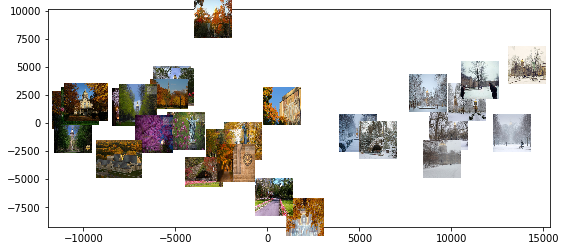

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom):
  return OffsetImage(plt.imread(path), zoom=zoom)

def PCA_Calculator(X, n_components):
  pca = PCA(n_components=n_components, whiten=False).fit(X)
  components = pca.transform(X)
  return pca, components

def PCA_ImageSpaceVisualization(X):

  pca, components = PCA_Calculator(X, 2)

  pca_result_df = pd.DataFrame(components, index=X.index.values)
  x = pca_result_df[0]
  y = pca_result_df[1]
  image_path = pca_result_df.index.values

  fig, ax = plt.subplots(figsize=(9,4))
  ax.scatter(x, y) 

  for index, row in pca_result_df.iterrows():
    ab = AnnotationBbox(getImage(index, 0.15), (row[0], row[1]), frameon=False)
    ax.add_artist(ab)
    ax.autoscale()

  return pca, components

#call
pca, pca_components = PCA_ImageSpaceVisualization(seasons.T)
  

3.
>3.1  Classification Accuracy is the ratio of number of correct predictions to the total number of input samples.
        $$Classification Accuracy = 
        \frac{Number Of Correct Predictions}{Total Number Of predicitons Made}$$
  It works well only if there are equal number of samples belonging to each class.



---


>3.2 Accuracy comparison between 1-NN and linear support vector machine - SVM as far as it concerns the season the picture was captured.
For the SVM i used the sklearn function [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html).
  LinearSVC is similar to *SVC* with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples. This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

In [83]:
import numpy as np 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics

def svm_clf(X, y):
  #clf = svm.SVC(kernel='linear', C=1.0, random_state=0)
  clf = svm.LinearSVC(C=1.0, max_iter = 3500) # Linear Kernel
  scores = cross_val_score(clf, X, y, cv=6, scoring='accuracy')  
  return scores, scores.mean()

##works with default 1-NN - 
##can work with other number of neighbours as well
def knn(X, y, n_neighbors=1):
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  scores = cross_val_score(knn, X, y, cv=6, scoring='accuracy')
  return scores, scores.mean()


>3.3 From the 30 samples, due to the fact that our data can be considered small in size, we see from the graphs below that in order to achive around 80-90% accuracy for the PCA we need at least 8 components with the optimal being 15 components.

array([0.46414464, 0.09279307, 0.05885481, 0.04799599, 0.03897451,
       0.03278999, 0.02778086, 0.02472745, 0.01983353, 0.01805825])

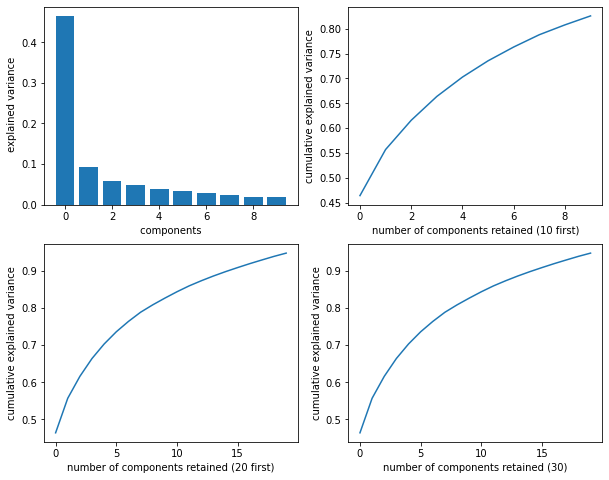

In [109]:
import matplotlib.pyplot as plt

pca, pca_components = PCA_Calculator(seasons.T, 20)

display(pca.explained_variance_ratio_[:10])

#print(pca.singular_values_)

cumExplainedVar=np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 8))
numOfComp=10
plt.subplot(2, 2, 1)
plt.bar(range(numOfComp),pca.explained_variance_ratio_[:numOfComp])
plt.xlabel(' components ')
plt.ylabel(' explained variance');

plt.subplot(2, 2, 2)
plt.plot(cumExplainedVar[:10])
plt.xlabel('number of components retained (10 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 3)
plt.plot(cumExplainedVar[:20])
plt.xlabel('number of components retained (20 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 4)
plt.plot(cumExplainedVar)
plt.xlabel('number of components retained (30)')
plt.ylabel('cumulative explained variance');

plt.show()

>3.4 It is clear from the results below that depending on the data each algorithm is given as input, we observe a different behaviour. 
SVM reports a better prediction score than 1-NN if PCA is previously applied on the input data. On the other hand 1-NN provides us with a better prediction with the Complete Data given as input. These results, show that in the case where the data were the principal components extracted with PCA, the SVM outperforms KNN, since the input data are linearly separable.

In [86]:
pca, pca_components = PCA_Calculator(seasons.T, 8)

sc = StandardScaler()

sc.fit(seasons.T)
sc.fit(np.array(img_label_arr).reshape(-1, 1))
seasons_std = sc.transform(seasons.T)


sc.fit(pca_components)
pca_seasons_std = sc.transform(pca_components)

results = pd.DataFrame([])

svm_complete = svm_clf(seasons_std, img_label_arr)
knn_complete = knn(seasons_std, img_label_arr,1)
data_sr_svm = pd.Series(svm_complete,name='SVM Complete Data')
data_sr_knn = pd.Series(knn_complete,name='1-NN Complete Data')
results = results.append(data_sr_svm)
results = results.append(data_sr_knn)

svm_pca = svm_clf(pca_seasons_std , img_label_arr)
knn_pca = knn(pca_seasons_std , img_label_arr, 1)
pca_data_sr_svm = pd.Series(svm_pca,name='SVM PCA')
pca_data_sr_knn = pd.Series(knn_pca,name='1-NN PCA')
results = results.append(pca_data_sr_svm)
results = results.append(pca_data_sr_knn)

results = results.rename(columns={0: "Accuracy Scores", 1: "Average Accuracy Scores"}, errors="raise")

display(results)


,Accuracy Scores,Average Accuracy Scores
SVM Complete Data,"[0.8, 0.6, 0.8, 0.4, 0.6, 0.6]",0.633333
1-NN Complete Data,"[0.8, 0.8, 1.0, 0.6, 0.8, 0.8]",0.800000
SVM PCA,"[0.8, 0.8, 1.0, 0.6, 0.8, 0.8]",0.800000
1-NN PCA,"[0.8, 0.8, 0.6, 0.6, 0.6, 0.6]",0.666667


#Part 2

Regularized non-negative matrix factorization - regNMF

---




In [88]:
import numpy as np
import numpy.linalg as LA


# W : matrix of basis vectors
# C : matrix of coefficients
# frob_error : frobenius norm
def frobenius_norm(X,W,C):
		#error between X and W*H
		error = LA.norm(X - np.dot(W, C))
		return error

def update_c(X,W,C, Lambda):
  numerator = np.dot(W.T, X) - np.dot(Lambda, C)
  denominator = np.dot(W.T.dot(W), C )
  C *= numerator
  C /= denominator
  return C

def update_w(X,W,C, Lambda):

  numerator = X.dot(C.T) - np.dot(Lambda, W)
  denominator = W.dot(C.dot(C.T)) 
  W *= numerator
  W /= denominator
  return W

def termination_Condition(epsilon, current, previous):
  dif = current-previous
  if(epsilon > abs(dif)):
    return True
  return False

def RegNMF(X,k,Lambda,epsilon):
  
  max_iter = 1000

  X_dim, samples = X.shape

  W = np.random.random((X_dim, k))

  C = np.random.random((k, samples))

  frob_error = np.zeros(max_iter)

  for i in range(max_iter):

    wNew = update_w(X,W,C, Lambda)
    cNew = update_c(X,W,C, Lambda)
    frob_error[i] = frobenius_norm(X,wNew,cNew)

    if (i > 0 and termination_Condition(epsilon=epsilon, current=frob_error[i], previous=frob_error[i-1])):
      break;

  return (wNew,cNew,frob_error, i)


>Create a random array to test the regNMF algorithm 

In [89]:
import pandas as pd

def RandomArray():
  X = np.random.rand(500, 1000)
  X = pd.DataFrame(X)
  X.apply(lambda x : x.abs())
  return X

X = RandomArray()
#display(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.685450,0.972128,0.933066,0.273931,0.216709,0.456043,0.919845,0.617077,0.374721,0.963074,0.440910,0.228440,0.627648,0.633016,0.269044,0.363650,0.850109,0.232942,0.393617,0.776022,0.971107,0.931327,0.483846,0.756343,0.424478,0.831081,0.114864,0.770580,0.735558,0.947556,0.113697,0.160275,0.755872,0.859415,0.846277,0.886705,0.646781,0.945391,0.157776,0.744310,...,0.698906,0.931457,0.939979,0.785438,0.540568,0.729113,0.830439,0.909178,0.966497,0.112223,0.851019,0.052374,0.905530,0.830293,0.630501,0.002081,0.441680,0.203758,0.435839,0.536580,0.635765,0.583094,0.724111,0.352441,0.436780,0.822041,0.194841,0.263264,0.591253,0.242387,0.646060,0.139530,0.192602,0.123440,0.610178,0.706289,0.277336,0.313334,0.683835,0.028337
1,0.831224,0.401245,0.970912,0.317091,0.844441,0.647860,0.025817,0.861747,0.247769,0.781650,0.667185,0.736772,0.305997,0.991552,0.466743,0.468604,0.030668,0.520883,0.523858,0.565341,0.200448,0.414610,0.846539,0.795153,0.134675,0.802846,0.778241,0.943788,0.473836,0.981802,0.304788,0.220124,0.254040,0.871545,0.082219,0.925485,0.521641,0.945039,0.211528,0.883902,...,0.017127,0.646329,0.437769,0.524378,0.363458,0.239844,0.447001,0.268415,0.154692,0.898764,0.619694,0.956269,0.785356,0.129038,0.550961,0.538413,0.148939,0.569711,0.100470,0.709052,0.237592,0.484191,0.785794,0.765061,0.846858,0.790054,0.575952,0.218290,0.525447,0.778010,0.871158,0.533146,0.219227,0.099726,0.156711,0.634490,0.386053,0.705718,0.074530,0.843992
2,0.508511,0.356008,0.851728,0.425847,0.884179,0.813731,0.382875,0.733984,0.058862,0.704553,0.415726,0.118685,0.437934,0.809547,0.359444,0.305548,0.662178,0.282633,0.734420,0.084930,0.460856,0.427775,0.546777,0.709311,0.787197,0.298634,0.459002,0.705511,0.258887,0.865788,0.259695,0.479218,0.687812,0.660361,0.757202,0.155442,0.751815,0.569873,0.803319,0.666922,...,0.588005,0.077205,0.539611,0.939692,0.973750,0.802966,0.740749,0.788275,0.982162,0.337990,0.933360,0.392035,0.342771,0.160379,0.732994,0.544021,0.656302,0.840664,0.672182,0.679434,0.931683,0.584337,0.915534,0.682280,0.631953,0.620870,0.126343,0.755589,0.641564,0.553418,0.327495,0.134786,0.735804,0.114043,0.738682,0.114588,0.786643,0.586567,0.729025,0.684497
3,0.168722,0.568141,0.708290,0.663666,0.663663,0.121995,0.230592,0.885670,0.904858,0.275711,0.888199,0.693753,0.209838,0.186665,0.359308,0.890192,0.476110,0.881831,0.888656,0.178129,0.874100,0.490308,0.225805,0.139353,0.814760,0.903454,0.961563,0.865809,0.959610,0.786655,0.346467,0.881475,0.948904,0.615619,0.423163,0.089521,0.203111,0.618083,0.890074,0.889648,...,0.511695,0.735391,0.022727,0.562075,0.936346,0.740110,0.435318,0.102944,0.489822,0.625074,0.444246,0.526148,0.285875,0.196851,0.153879,0.575283,0.705959,0.724403,0.634037,0.700491,0.771083,0.854840,0.801557,0.036925,0.243616,0.172673,0.223243,0.124435,0.090551,0.190087,0.715526,0.675928,0.920962,0.029977,0.009227,0.980602,0.396593,0.245112,0.392385,0.822165
4,0.888025,0.526922,0.138303,0.280781,0.256085,0.743166,0.952009,0.700045,0.086536,0.542929,0.312681,0.960999,0.336092,0.383924,0.124043,0.337647,0.618418,0.172199,0.455381,0.139559,0.010802,0.063513,0.804231,0.684771,0.206799,0.423600,0.711772,0.626371,0.235577,0.679982,0.065112,0.040167,0.293813,0.678774,0.943183,0.035734,0.187297,0.240337,0.227700,0.947533,...,0.490366,0.652561,0.462167,0.735018,0.018686,0.173635,0.370590,0.126988,0.538746,0.119819,0.213970,0.918338,0.511834,0.478378,0.151260,0.562393,0.808547,0.911442,0.219519,0.576049,0.111997,0.509116,0.127593,0.086860,0.682409,0.736281,0.940746,0.716936,0.994433,0.611244,0.386205,0.585640,0.309706,0.723166,0.180752,0.624749,0.144712,0.463201,0.817258,0.156492


>Test the algorithm for values \
  k = [1, 10, 100]\
  epsilon = [0.1, 0.01, 0.001]\
  We choose $lambda = 10^{-9}$ to avoid possible division by $zero$


In [107]:
k = [1, 10, 100]
epsilon = [0.1, 0.01, 0.001]

columns = ['k', 'epsilon', 'repetitions']
results = pd.DataFrame(columns=columns)

for i in range(3):
  for j in range(3):
    wNew, cNew, frob_error, rep = RegNMF(X=X, k=k[i], Lambda=10^-9, epsilon=epsilon[j])
    results =  results.append({'k':k[i], 'epsilon': epsilon[j], 'repetitions': rep}, ignore_index=True)

display(results)

,k,epsilon,repetitions
0,1.0,0.100,2.0
1,1.0,0.010,3.0
2,1.0,0.001,3.0
3,10.0,0.100,2.0
4,10.0,0.010,72.0
5,10.0,0.001,142.0
6,100.0,0.100,39.0
7,100.0,0.010,176.0
8,100.0,0.001,375.0


>From the results above, we can observe that the greater the threshold $\varepsilon$ is and the smaller the number of the components $k$ the less are the repetitions the method takes to converge. 

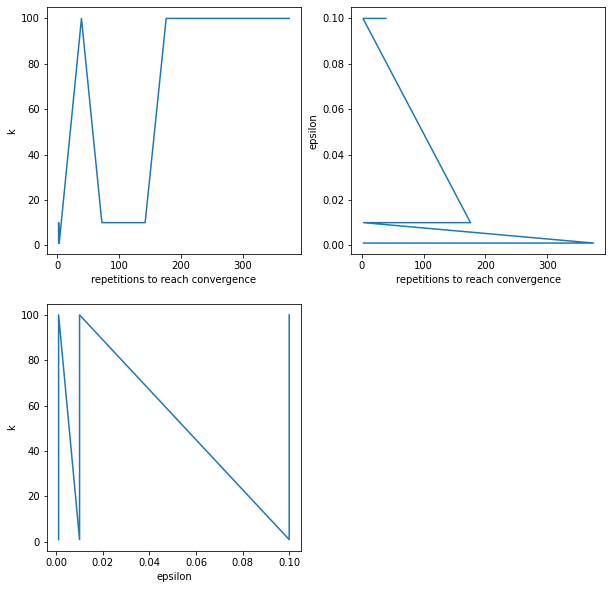

In [124]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(2, 2, 1)
results=results.sort_values(by=['repetitions'])
plt.plot(results['repetitions'], results['k'])
plt.xlabel('repetitions to reach convergence')
plt.ylabel('k');

plt.subplot(2, 2, 2)
results=results.sort_values(by=['epsilon'])
plt.plot(results['repetitions'], results['epsilon'])
plt.xlabel('repetitions to reach convergence')
plt.ylabel('epsilon');

plt.subplot(2, 2, 3)
plt.plot(results['epsilon'], results['k'])
plt.xlabel('epsilon')
plt.ylabel('k');